# Titanic K-fold 교차검증

## import & Dataset LOAD

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score #Confusion matrix 수업 때 진행할 예정 
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [3]:
df_train = pd.read_csv('../lecture/train.csv')
df_test = pd.read_csv('../lecture/test.csv')

In [4]:
df_train.shape , df_test.shape

((891, 12), (418, 11))

## EDA

In [5]:
df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### 데이터 확인

In [6]:
# 범주형 변수들 확인 
category_lst = ['Pclass','Parch','SibSp','Embarked','Cabin']
def unique(df):
    for i in category_lst:
        print(df[i].unique())
unique(df_train)

[3 1 2]
[0 1 2 5 3 4 6]
[1 0 3 4 2 5 8]
['S' 'C' 'Q' nan]
[nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50'


In [7]:
# 결측치 확인
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### 결측치 처리 , 정규화

In [8]:
# 결측치 처리 
def null_pre(df):
    # age 결측치 평균으로 대치 
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    # Embarked 결측치가 있는 행 2개 제거 
    df.dropna(subset=['Embarked'], inplace=True)
    # cabin 결측치 N으로 처리하고 cabin 분류 앞글자만 따서 분류
    df_train['Cabin'].fillna('N',inplace=True)
    df_train['Cabin'] = df_train['Cabin'].apply(lambda x:x[0])
    
# 필요 없는 column 제거 
def drop_features(df):
    return df.drop(['Ticket', 'Name'], axis=1,inplace=True)

null_pre(df_train)
drop_features(df_train)

In [9]:
df_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [10]:
# 범주 확인 다시 
category_lst = ['Pclass','Parch','SibSp','Embarked','Cabin']
def unique(df):
    for i in category_lst:
        print(df[i].unique())
unique(df_train)

[3 1 2]
[0 1 2 5 3 4 6]
[1 0 3 4 2 5 8]
['S' 'C' 'Q']
['N' 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


c:\Users\User\document\ML study\tset\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\document\ML study\tset\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


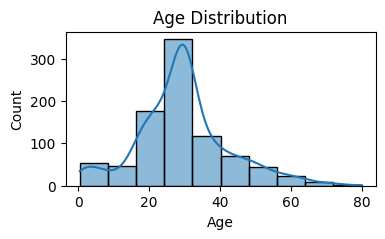

In [11]:
# 연속형 변수 분포 확인을 위해 시각화
def plot_histogram(data, column_name, bins=10, kde=True):
    plt.figure(figsize=(4, 2))
    sns.histplot(data=data, x=column_name, bins=bins, kde=kde)
    plt.title(f'{column_name} Distribution')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.show()
    
plot_histogram(data=df_train, column_name='Age', bins=10, kde=True)

c:\Users\User\document\ML study\tset\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\document\ML study\tset\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


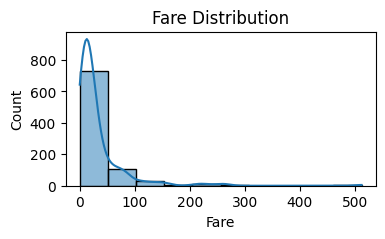

In [12]:
plot_histogram(data=df_train, column_name='Fare', bins=10, kde=True)

In [13]:
# df_train["Fare"] = df_train["Fare"].map(lambda i: i**2) # 제곱 변환은 별로 개선이 안된다 
# df_train["Fare"] = df_train["Fare"].map(lambda i: np.sqrt(i) ) #제곱근 변환도 별로 도움 안되더라  
df_train["Fare"] = df_train["Fare"].map(lambda i: np.log(i) if i > 0 else 0) # 로그 변환은 그나마 개선 

c:\Users\User\document\ML study\tset\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\document\ML study\tset\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


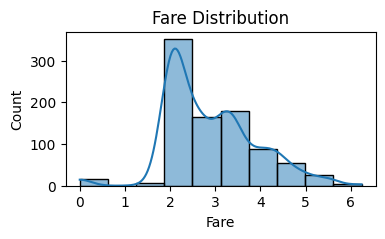

In [14]:
plot_histogram(data=df_train, column_name='Fare', bins=10, kde=True)

In [15]:
df_train = pd.get_dummies(df_train, columns=['Sex','Cabin','Embarked'])

### 분리 및 학습

In [16]:
features = df_train.drop(['Survived'],axis=1)
label = df_train['Survived']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=111)

In [18]:
X_train

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
434,435,1,50.000000,1,0,4.023564,False,True,False,False,False,False,True,False,False,False,False,False,False,True
168,169,1,29.699118,0,0,3.255208,False,True,False,False,False,False,False,False,False,True,False,False,False,True
714,715,2,52.000000,0,0,2.564949,False,True,False,False,False,False,False,False,False,True,False,False,False,True
513,514,1,54.000000,1,0,4.084294,True,False,False,False,False,False,False,False,False,True,False,True,False,False
146,147,3,27.000000,0,0,2.053585,False,True,False,False,False,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,277,3,45.000000,0,0,2.047693,True,False,False,False,False,False,False,False,False,True,False,False,False,True
87,88,3,29.699118,0,0,2.085672,False,True,False,False,False,False,False,False,False,True,False,False,False,True
725,726,3,20.000000,0,0,2.159003,False,True,False,False,False,False,False,False,False,True,False,False,False,True
878,879,3,29.699118,0,0,2.066331,False,True,False,False,False,False,False,False,False,True,False,False,False,True


In [19]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train) #모델 학습
pred_train = model.predict(X_train) #train 예측
pred_test = model.predict(X_test) # test예측

model_sp1 = DecisionTreeClassifier(random_state=111, max_depth=3)
model_sp1.fit(X_train, y_train) #모델 학습
pred_train_sp = model_sp1.predict(X_train) #train 예측
pred_test_sp = model_sp1.predict(X_test) # test예측

In [20]:
print(accuracy_score(y_train, pred_train))
print(accuracy_score(y_test, pred_test))

1.0
0.7808988764044944


In [21]:
print(accuracy_score(y_train, pred_train_sp))
print(accuracy_score(y_test, pred_test_sp))

0.8171589310829818
0.848314606741573


## k-fold

### 일반 kfold

In [28]:
kfold= KFold(n_splits=5) 
n_iter=0
kfold_cv_accuracy_train = []
kfold_cv_accuracy_train_cv_accuracy_test = []
model = DecisionTreeClassifier(random_state=111, max_depth=3)

for train_idx, test_idx in kfold.split(features, label):
    X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
    y_train, y_test = label.iloc[train_idx], label.iloc[test_idx]
    
    #학습을 위해서 dt배우기
    model.fit(X_train, y_train)
    #예측
    skf_pred_train = model.predict(X_train)
    skf_pred_test = model.predict(X_test)
    
    #정확도를 5번 측정하면서 값에 넣을 것이니
    n_iter +=1
    accuracy_train = np.round(accuracy_score(y_train, skf_pred_train),4)
    accuracy_test = np.round(accuracy_score(y_test, skf_pred_test),4)
    
    print('\n{} 번 train 교차 검증 정확도 :{} ,test 교차 검증 정확도 :{} '.format(n_iter,accuracy_train, accuracy_test))
    
    kfold_cv_accuracy_train.append(accuracy_train)
    kfold_cv_accuracy_train_cv_accuracy_test.append(accuracy_test)
    
print('train 평균 정확도',np.mean(kfold_cv_accuracy_train))
print('test 평균 정확도',np.mean(kfold_cv_accuracy_train_cv_accuracy_test))


1 번 train 교차 검증 정확도 :0.8256 ,test 교차 검증 정확도 :0.7978 

2 번 train 교차 검증 정확도 :0.8115 ,test 교차 검증 정확도 :0.7978 

3 번 train 교차 검증 정확도 :0.8284 ,test 교차 검증 정확도 :0.8034 

4 번 train 교차 검증 정확도 :0.8425 ,test 교차 검증 정확도 :0.7697 

5 번 train 교차 검증 정확도 :0.8104 ,test 교차 검증 정확도 :0.8418 
train 평균 정확도 0.8236799999999999
test 평균 정확도 0.8021


### 일반 skf kfold

In [ ]:
skf_titanic = StratifiedKFold(n_splits=5)
n_iter=0
skf_cv_accuracy_train = []
skf_cv_accuracy_test = []
model = DecisionTreeClassifier(random_state=111, max_depth=3)

for train_idx, test_idx in skf_titanic.split(features, label):
    X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
    y_train, y_test = label.iloc[train_idx], label.iloc[test_idx]
    
    #학습을 위해서 dt배우기
    model.fit(X_train, y_train)
    #예측
    skf_pred_train = model.predict(X_train)
    skf_pred_test = model.predict(X_test)
    
    #정확도를 5번 측정하면서 값에 넣을 것이니
    n_iter +=1
    accuracy_train = np.round(accuracy_score(y_train, skf_pred_train),4)
    accuracy_test = np.round(accuracy_score(y_test, skf_pred_test),4)
    
    print('\n{} 번 train 교차 검증 정확도 :{} ,test 교차 검증 정확도 :{} '.format(n_iter,accuracy_train, accuracy_test))
    
    skf_cv_accuracy_train.append(accuracy_train)
    skf_cv_accuracy_test.append(accuracy_test)
    
print('train 평균 정확도',np.mean(skf_cv_accuracy_train))
print('test 평균 정확도',np.mean(skf_cv_accuracy_test))


1 번 train 교차 검증 정확도 :0.8284 ,test 교차 검증 정확도 :0.6854 

2 번 train 교차 검증 정확도 :0.82 ,test 교차 검증 정확도 :0.809 

3 번 train 교차 검증 정확도 :0.827 ,test 교차 검증 정확도 :0.8034 

4 번 train 교차 검증 정확도 :0.8397 ,test 교차 검증 정확도 :0.7809 

5 번 train 교차 검증 정확도 :0.8146 ,test 교차 검증 정확도 :0.8249 
train 평균 정확도 0.8259399999999999
test 평균 정확도 0.78072


### ->결론 과적합이 크게 나타나지 않았는데 kfold를 적용시키니 오히려 정확도가 떨어졌다